<a href="https://colab.research.google.com/github/anubhavgupta1/DeepLearning/blob/master/13_Deep_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception v3

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset, transforms, and visualisation

In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

0it [00:00, ?it/s]

170500096it [00:04, 40871279.63it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
num_classes = 10

In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
5


In [0]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [0]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

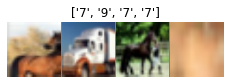

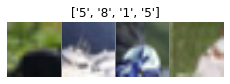

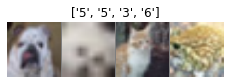

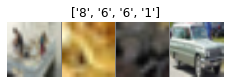

In [10]:
for i in range(4):
    show_batch_images(trainloader)

## Creating VGG-16

https://pytorch.org/docs/master/_modules/torchvision/models/vgg.html

In [0]:
from torchvision import models

In [0]:
vgg = models.vgg16_bn()

In [13]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [14]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [15]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [16]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [17]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Train CIFAR10

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.50
Iteration: 100/3125, Loss: 4.01
Iteration: 200/3125, Loss: 2.18
Iteration: 300/3125, Loss: 2.70
Iteration: 400/3125, Loss: 2.24
Iteration: 500/3125, Loss: 2.22
Iteration: 600/3125, Loss: 2.28
Iteration: 700/3125, Loss: 2.25
Iteration: 800/3125, Loss: 2.38
Iteration: 900/3125, Loss: 2.23
Iteration: 1000/3125, Loss: 2.35
Iteration: 1100/3125, Loss: 2.34
Iteration: 1200/3125, Loss: 2.37
Iteration: 1300/3125, Loss: 2.20
Iteration: 1400/3125, Loss: 2.28
Iteration: 1500/3125, Loss: 2.21
Iteration: 1600/3125, Loss: 2.64
Iteration: 1700/3125, Loss: 2.25
Iteration: 1800/3125, Loss: 2.26
Iteration: 1900/3125, Loss: 2.21
Iteration: 2000/3125, Loss: 2.09
Iteration: 2100/3125, Loss: 1.99
Iteration: 2200/3125, Loss: 2.67
Iteration: 2300/3125, Loss: 2.18
Iteration: 2400/3125, Loss: 2.25
Iteration: 2500/3125, Loss: 2.28
Iteration: 2600/3125, Loss: 2.15
Iteration: 2700/3125, Loss: 1.98
Iteration: 2800/3125, Loss: 2.30
Iteration: 2900/3125, Loss: 2.25
Iteration: 3000/3125, 

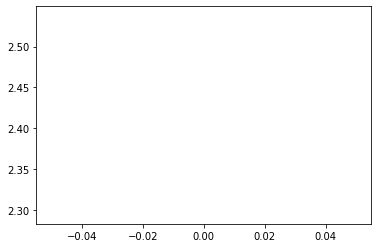

In [25]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
plt.plot(loss_epoch_arr)
plt.show()

### Freeze layers of Convolutional Operations

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [27]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:08<00:00, 65.6MB/s]


In [0]:
for param in vgg.parameters():
    param.requires_grad = False

In [0]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [30]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.39
Iteration: 100/3125, Loss: 1.79
Iteration: 200/3125, Loss: 2.27
Iteration: 300/3125, Loss: 1.27
Iteration: 400/3125, Loss: 1.52
Iteration: 500/3125, Loss: 2.50
Iteration: 600/3125, Loss: 2.42
Iteration: 700/3125, Loss: 2.56
Iteration: 800/3125, Loss: 2.28
Iteration: 900/3125, Loss: 2.46
Iteration: 1000/3125, Loss: 1.43
Iteration: 1100/3125, Loss: 2.14
Iteration: 1200/3125, Loss: 2.36
Iteration: 1300/3125, Loss: 2.37
Iteration: 1400/3125, Loss: 1.41
Iteration: 1500/3125, Loss: 2.21
Iteration: 1600/3125, Loss: 2.73
Iteration: 1700/3125, Loss: 2.31
Iteration: 1800/3125, Loss: 2.69
Iteration: 1900/3125, Loss: 1.87
Iteration: 2000/3125, Loss: 2.81
Iteration: 2100/3125, Loss: 1.29
Iteration: 2200/3125, Loss: 2.44
Iteration: 2300/3125, Loss: 2.34
Iteration: 2400/3125, Loss: 1.86
Iteration: 2500/3125, Loss: 1.33
Iteration: 2600/3125, Loss: 2.74
Iteration: 2700/3125, Loss: 1.25
Iteration: 2800/3125, Loss: 1.30
Iteration: 2900/3125, Loss: 2.41
Iteration: 3000/3125, 

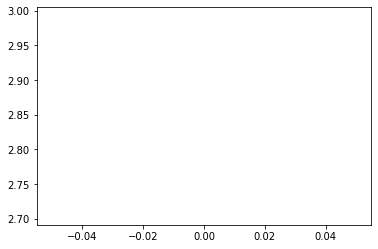

In [32]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

### With model copies

In [0]:
import copy

In [34]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

Min loss 3.32
Iteration: 0/3125, Loss: 3.32
Min loss 1.82
Min loss 1.62
Min loss 1.61
Min loss 1.56
Min loss 1.29
Min loss 1.21
Min loss 1.04
Min loss 0.96
Iteration: 100/3125, Loss: 2.55
Min loss 0.79
Iteration: 200/3125, Loss: 2.32
Iteration: 300/3125, Loss: 2.09
Iteration: 400/3125, Loss: 1.50
Min loss 0.72
Iteration: 500/3125, Loss: 2.34
Iteration: 600/3125, Loss: 1.85
Iteration: 700/3125, Loss: 1.92
Iteration: 800/3125, Loss: 2.24
Iteration: 900/3125, Loss: 2.67
Min loss 0.57
Iteration: 1000/3125, Loss: 0.57
Iteration: 1100/3125, Loss: 2.15
Iteration: 1200/3125, Loss: 3.23
Iteration: 1300/3125, Loss: 1.79
Iteration: 1400/3125, Loss: 3.31
Iteration: 1500/3125, Loss: 3.32
Iteration: 1600/3125, Loss: 2.01
Iteration: 1700/3125, Loss: 1.78
Iteration: 1800/3125, Loss: 3.06
Iteration: 1900/3125, Loss: 1.65
Iteration: 2000/3125, Loss: 2.24
Iteration: 2100/3125, Loss: 2.89
Iteration: 2200/3125, Loss: 2.45
Iteration: 2300/3125, Loss: 3.43
Iteration: 2400/3125, Loss: 2.20
Iteration: 2500/312

In [35]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

44.322 44.46


## ResNet Model

https://pytorch.org/docs/master/_modules/torchvision/models/resnet.html

In [36]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 44.6MB/s]


In [37]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in resnet.parameters():
    param.requires_grad = False

In [0]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [40]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

Min loss 2.36
Iteration: 0/3125, Loss: 2.36
Min loss 2.27
Min loss 2.20
Min loss 2.16
Min loss 2.15
Min loss 2.07
Min loss 1.94
Min loss 1.75
Min loss 1.68
Min loss 1.65
Iteration: 100/3125, Loss: 1.68
Min loss 1.62
Min loss 1.58
Min loss 1.40
Min loss 1.31
Iteration: 200/3125, Loss: 1.54
Min loss 1.31
Min loss 1.24
Min loss 1.19
Iteration: 300/3125, Loss: 1.29
Min loss 1.16
Min loss 1.04
Min loss 0.99
Iteration: 400/3125, Loss: 1.68
Min loss 0.96
Iteration: 500/3125, Loss: 1.26
Min loss 0.95
Min loss 0.77
Iteration: 600/3125, Loss: 1.50
Min loss 0.77
Iteration: 700/3125, Loss: 1.30
Iteration: 800/3125, Loss: 1.09
Iteration: 900/3125, Loss: 1.47
Min loss 0.70
Iteration: 1000/3125, Loss: 1.27
Min loss 0.67
Iteration: 1100/3125, Loss: 1.62
Iteration: 1200/3125, Loss: 1.08
Min loss 0.47
Iteration: 1300/3125, Loss: 1.34
Iteration: 1400/3125, Loss: 1.52
Iteration: 1500/3125, Loss: 1.51
Iteration: 1600/3125, Loss: 0.70
Iteration: 1700/3125, Loss: 1.21
Iteration: 1800/3125, Loss: 1.77
Iterati

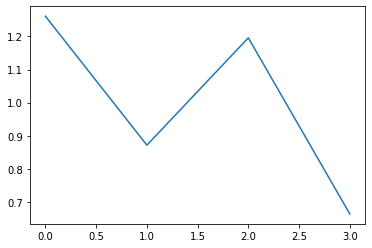

In [42]:
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [43]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

56.414 56.01


## Inception Model

https://pytorch.org/docs/master/_modules/torchvision/models/inception.html

In [44]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:02<00:00, 53.9MB/s] 


In [45]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [0]:
for param in inception.parameters():
    param.requires_grad = False

In [0]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [48]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [0]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [50]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [52]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [0]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 2.99
Iteration: 0/3125, Loss: 2.99
Min loss 2.95
Min loss 2.90
Min loss 2.87
Min loss 2.81
Min loss 2.80
Min loss 2.79
Min loss 2.78
Min loss 2.72
Min loss 2.71
Min loss 2.69
Min loss 2.65
Min loss 2.63
Min loss 2.62
Min loss 2.60
Min loss 2.59
Min loss 2.48
Min loss 2.46
Iteration: 100/3125, Loss: 2.91
Min loss 2.45
Min loss 2.35
Min loss 2.30
Iteration: 200/3125, Loss: 2.68
Min loss 2.28
Min loss 2.28
Min loss 2.19
Min loss 2.09
Min loss 2.03
Iteration: 300/3125, Loss: 2.37
Min loss 2.02
Min loss 1.98
Min loss 1.78
Iteration: 400/3125, Loss: 2.31
Iteration: 500/3125, Loss: 2.03
Min loss 1.76
Min loss 1.74
Iteration: 600/3125, Loss: 2.03
Iteration: 700/3125, Loss: 1.90
Min loss 1.63
Min loss 1.56
Iteration: 800/3125, Loss: 1.95
Min loss 1.50
Iteration: 900/3125, Loss: 2.00
Iteration: 1000/3125, Loss: 1.88
Min loss 1.23
Iteration: 1100/3125, Loss: 2.25
Iteration: 1200/3125, Loss: 1.72
Iteration: 1300/3125, Loss: 1.92
Iteration: 1400/3125, Loss: 2.33
Iteration: 1500/3125, Loss:

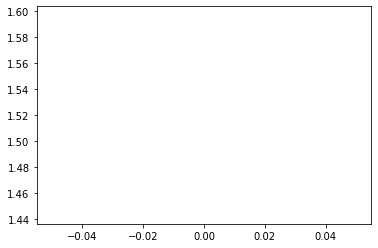

In [56]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [57]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

46.244 46.62
